# PCNN Implementation with Remote Sensing Images
In this notebook input images are used from MODIS Terra satellite from NASA. Here one sample .hdf file is used for input and rest of the implementation is done in Pulse Coupled Neural Network (PCNN).
There is one data folder where the .hdf file is located. That file is downloaded from NASA LAADS DAAC.

##### All the Necessary packages and libraries are loaded

In [279]:
from scipy.signal import cspline2d
import imageio as img
from PIL import Image

%matplotlib notebook

from satpy import Scene, MultiScene, available_readers, available_writers, find_files_and_readers
from satpy.readers import modis_l1b, modis_l2
from satpy.writers import get_enhanced_image
from satpy.composites import GenericCompositor

from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyresample import geometry

import os
import warnings

import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

from datetime import datetime

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img

import tensorflow as tf

## Module 1: Remote Sensing MODIS Data
##### Checking the directory to find the location of data

In [280]:
os.getcwd()

'/Users/nurul_rafi1/earth-analytics/PCNN/data'

##### Changing the folder to data to get access of the .hdf file
This file is downloaded before from NASA LAADS DAAC. Changing the directory should be executed only once otherwise it will show error because it has already changed the directory.


In [281]:
# Set working directory to data to get access of the file
# os.chdir(os.path.join(os.getcwd(), 'data'))

# Accessing file for processing
filename = os.path.join("MOD021KM.A2021092.0020.006.2021092134055.hdf")
filenames = [filename]

##### Loading data to scene object from SatPy. 
SatPy is used here for processing remote sensing images
Printing available dataset names which is required for listing the bands
Here total 36 bands information are available

In [282]:
# MODIS scene object using the file retrieved from data folder
modis_scene = Scene(reader='modis_l1b', filenames=filenames)
modis_scene.available_dataset_names()
# modis_scene.unload

['1',
 '10',
 '11',
 '12',
 '13hi',
 '13lo',
 '14hi',
 '14lo',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

##### Method: Band Details and Plotting
This is the custom method which takes band no and color map as parameter and shows all the necessary information about that particular band. The second method plot_band() takes the band no as parameter and plot the band.

In [283]:
def band_details(band_no, cmap):
    
    print("Band no: ", band_no)
    print("Platform name: ", modis_scene[band_no].attrs['platform_name'])
    print("Dimension: ", modis_scene[band_no].dims)
    print("No of dimension: ", modis_scene[band_no].ndim)
    print("Wavelength: ", modis_scene[band_no].wavelength)
    print("Calibration: ", modis_scene[band_no].calibration)
    print("Maximum value: ", modis_scene[band_no].max().values)
    
    modis_scene[band_no].plot.imshow(cmap=cmap)
    plt.title("Band-{}".format(band_no))

def plot_band(band_no):

    plt.figure()
    modis_scene.load([band_no])
    band_details(band_no, 'cividis')
    modis_scene[band_no]

<IPython.core.display.Javascript object>


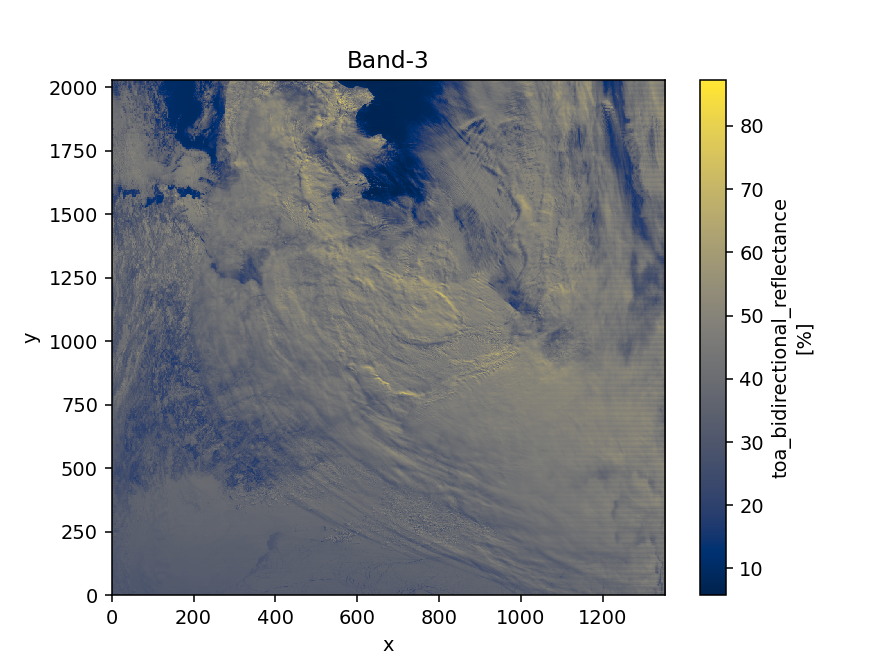

Band no:  3
Platform name:  EOS-Terra
Dimension:  ('y', 'x')
No of dimension:  2
Wavelength:  0.469 µm (0.459-0.479 µm)
Calibration:  reflectance
Maximum value:  87.313065


In [284]:
band_no = '3'
plot_band(band_no)

## Module 2: Basic PCNN

This is the basic construction of PCNN. It contains the initialization and pulse method. PCNN is usually an array which contains all the pixels of input image and every pixel works as a neuron in PCNN.<br>

#### Initialization
- F defines feeding compartment
\begin{align} 
F_{i j}[n]= & e^{-\alpha_{F}} F_{i j}[n-1]+S_{i j} +V_{F} \sum_{k l} M_{i j, k l} Y_{k l}[n-1] 
\end{align}
- L defiens linking compartment
\begin{align}
    L_{i j}[n]=e^{-\alpha_{L}} L_{i j}[n-1]+V_{L} \sum_{k l} W_{i j, k l} Y_{k l}[n-1]
\end{align}
- E defines threshold value
\begin{align}
E_{i j}[n]=e^{-\alpha_{E}} E_{i j}[n-1]+V_{E} Y_{i j}[n-1]
\end{align}
- U defines the internal activity
\begin{align}
U_{i j}[n]=F_{i j}[n]\left[1+\beta L_{i j}[n]]\right.
\end{align}

- Y defines the output
\begin{align}
Y=\left\{\begin{array}{ll}
1, & \text { if } U_{i j}[n]>E_{i j}[n] \\
0, & \text { otherwise }
\end{array}\right\}
\end{align}

Initially all the F, L, T and Y values are set to zero and threshold is set to little bit higher.
The constant values are set at first. 

- edfF, edfL, edfE defines the exponential decay factor of feeding, linking and threshold accordingly.
- vE is the linking amplification coefficient
- vF and vL are inherent voltage potentials
- beta is the linking strength

#### Pulse 
Pulse method receive the input and implement PCNN on it. Pulse is generated for n-th iteration that is controlled by the user. 


In [285]:
class PCNN:
    
    edfF = 0.9
    edfL = 0.8
    edfE = 0.8
    vE = 50.0
    beta = 0.2
    vF = 8.0
    vL = 8.0

    def __init__ (self, dim):
        
        self.F = np.zeros(dim, float)
        self.L = np.zeros(dim, float)
        self.E = np.zeros(dim, float) + 0.0001
        self.Y = np.zeros(dim, float)
        
        
    def pulse (self, inp):
        
        if self.Y.sum() > 0:
            previous_pulse = cspline2d(self.Y.astype(float), 90)
        else:
            previous_pulse = np.zeros(self.Y.shape, float)
            
        self.F = self.edfF * self.F + inp + self.vF * previous_pulse
        self.L = self.edfL * self.L + self.vL * previous_pulse
        U = self.F * (1 + self.beta * self.L)
        self.Y = U > self.E
        self.E = self.edfE * self.E + self.vE * self.Y + 0.1
    

### Data Extraction
Image data is extrcted from the metadata of MODIS hdf file

In [286]:
data = modis_scene[band_no]
data

<xarray.DataArray 'getitem-1fd2b7e9bc0dc75e44c7823ad81e2003' (y: 2030, x: 1354)>
dask.array<mul, shape=(2030, 1354), dtype=float32, chunksize=(2030, 1354), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes: (12/16)
    name:                 3
    resolution:           1000
    calibration:          reflectance
    coordinates:          ('longitude', 'latitude')
    wavelength:           0.469 µm (0.459-0.479 µm)
    file_type:            hdf_eos_data_1000m
    ...                   ...
    standard_name:        toa_bidirectional_reflectance
    start_time:           2021-04-02 00:20:00
    end_time:             2021-04-02 00:25:00
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray (y: 20...
    _satpy_id:            DataID(name='3', wavelength=WavelengthRange(min=0.4...
    ancillary_variables:  []

### Resizing Image
The dimension of input image is too high so the reduced dimension of image is used by resizing it to (128, 128) where original image dimension was (2030, 1354). Finally image value is normalized by dividing by 255. Image is first converted to matrix and then again to numpy array to match the dimension.

In [287]:
iteration = 100

image = resize(img_to_array(modis_scene[band_no]), (128, 128),  mode = 'constant', preserve_range = True)
image = image/255.0
image.shape
image = np.matrix(image)
image = np.array(image)
image


array([[0.08417404, 0.09997293, 0.10030717, ..., 0.13355288, 0.13453083,
        0.11186673],
       [0.09995108, 0.11542744, 0.11593973, ..., 0.15434417, 0.15176032,
        0.13112044],
       [0.09983622, 0.11592025, 0.11820783, ..., 0.1685168 , 0.14434215,
        0.13460653],
       ...,
       [0.07202932, 0.09845383, 0.13170718, ..., 0.2032884 , 0.19051538,
        0.16013288],
       [0.07438913, 0.09457238, 0.11344764, ..., 0.20032609, 0.19117616,
        0.16289563],
       [0.06532198, 0.08941291, 0.09118425, ..., 0.17055394, 0.16487616,
        0.1416021 ]], dtype=float32)

<IPython.core.display.Javascript object>


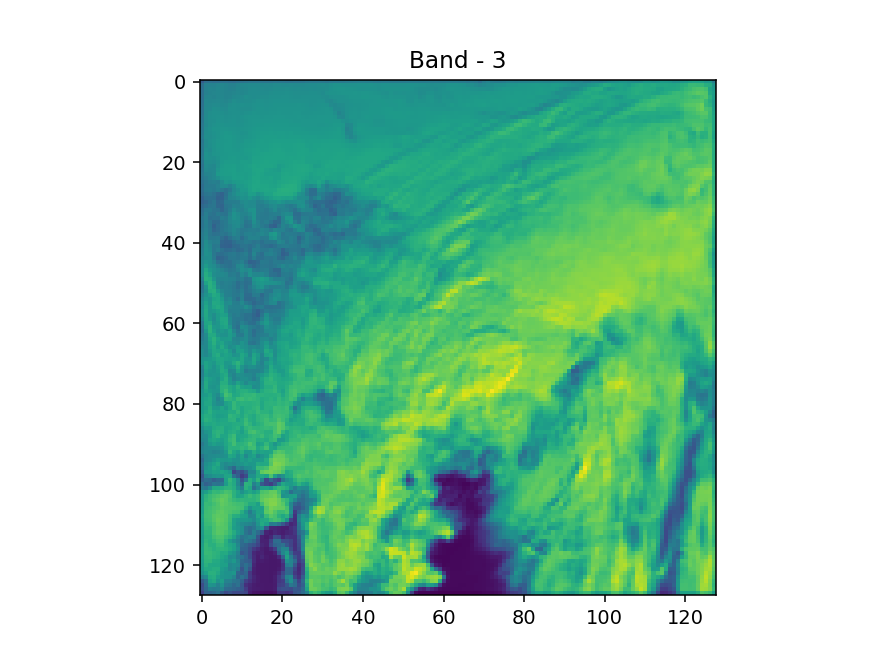

Text(0.5, 1.0, 'Band - 3')

In [288]:
# Plotting the image after resizing
plt.figure()
plt.imshow(image, cmap = 'viridis')
plt.title('Band - ' + band_no)

### Single Observation
Random observation of PCNN using input image

(128, 128)


<IPython.core.display.Javascript object>


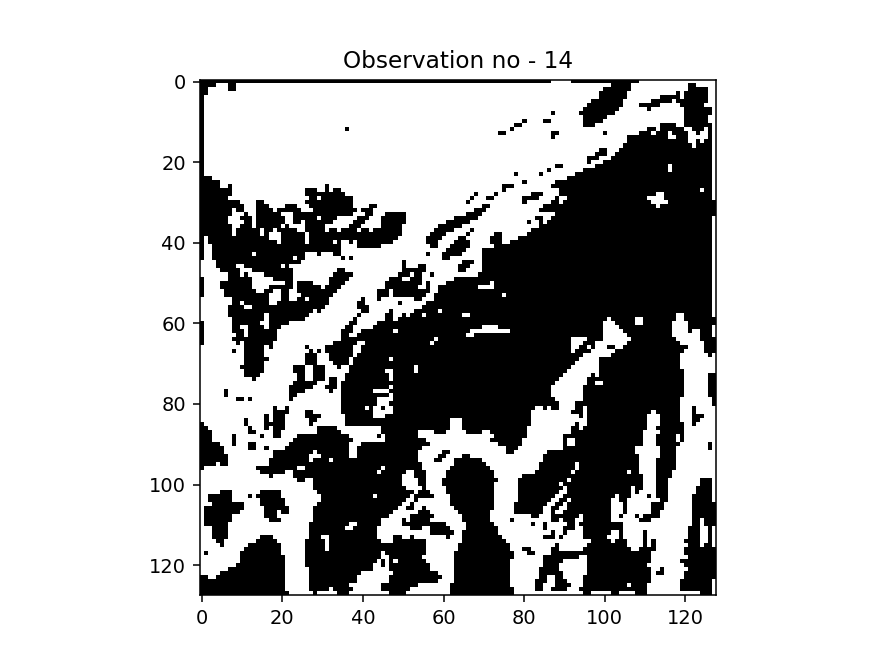

In [289]:
print(image.shape)
pcnn = PCNN(image.shape)
Y = []

plt.figure()
for i in range(15):
    pcnn.pulse(image)
    Y.append(pcnn.Y + 0)
    plt.imshow(Y[i], cmap=cm.Greys_r)
    plt.title("Observation no - {}".format(i))
    


### Model Observation
Observing all the iteration and all the values from F, L, E, U and Y

In [290]:
iteration = 50
pcnn = PCNN(image.shape)
F, L, U, Y, E = [], [], [], [], []

for i in range(iteration):
    pcnn.pulse(image)
    F.append(pcnn.F + 0)
    L.append(pcnn.L + 0)
    U.append(pcnn.F * (1 + pcnn.beta * pcnn.L))
    Y.append(pcnn.Y + 0)
    E.append(pcnn.E + 0)

### Oscillation and Visualization of Pulse of PCNN
Figures are saved to generate the oscillation of the model

In [291]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

def saveFigure():
    
    fig = plt.figure(figsize=(10, 2))
    for i in range(iteration):
  
      plt.subplot(151)
      plt.imshow(F[i], cmap=cm.Greys_r, animated=True)

      plt.colorbar()
      plt.title("$F["+str(i)+"]$")
      plt.axis('off')
      plt.subplot(152)
      plt.imshow(Y[i], cmap=cm.Greys_r, animated=True)
      plt.colorbar()
      plt.title("$Y["+str(i)+"]$")
      plt.axis('off')
      plt.subplot(153)
      plt.imshow(L[i], cmap=cm.Greys_r, animated=True)
      plt.colorbar()
      plt.title("$L["+str(i)+"]$")
      plt.axis('off')
      plt.subplot(154)
      plt.imshow(E[i], cmap=cm.Greys_r, animated=True)
      plt.colorbar()
      plt.title("$E["+str(i)+"]$")
      plt.axis('off')
      plt.subplot(155)
      plt.imshow(U[i], cmap=cm.Greys_r, animated=True)
      plt.colorbar()
      plt.title("$U["+str(i)+"]$")
      plt.axis('off')
      plt.savefig(str(i)+".png", bbox_inches='tight', dpi=150)
        
    plt.show()
    
    
def oscillation(name):
    
    frames = []
    fig = plt.figure(figsize=(10, 2))
    for i in range(iteration):
      image = plt.imread(str(i)+".png")
      frames.append([plt.imshow(image, cmap=cm.Greys_r,animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
    ani.save(name + '.mp4')
    plt.show()

### Visualization
Detailed visualization of pulse of PCNN

<IPython.core.display.Javascript object>


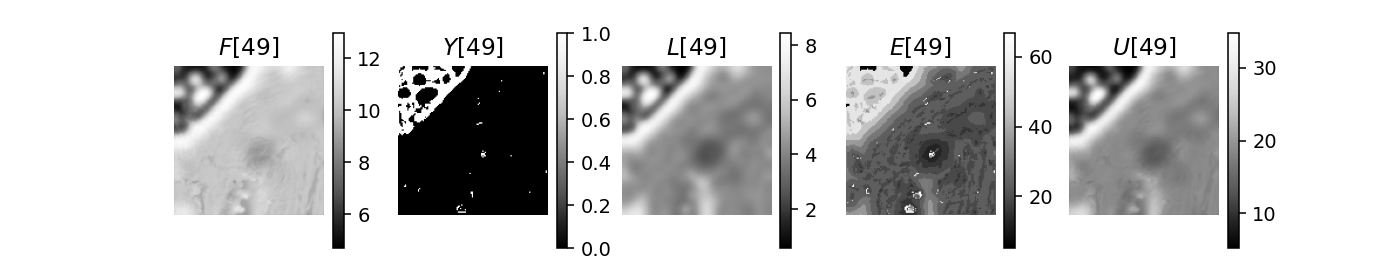

<IPython.core.display.Javascript object>


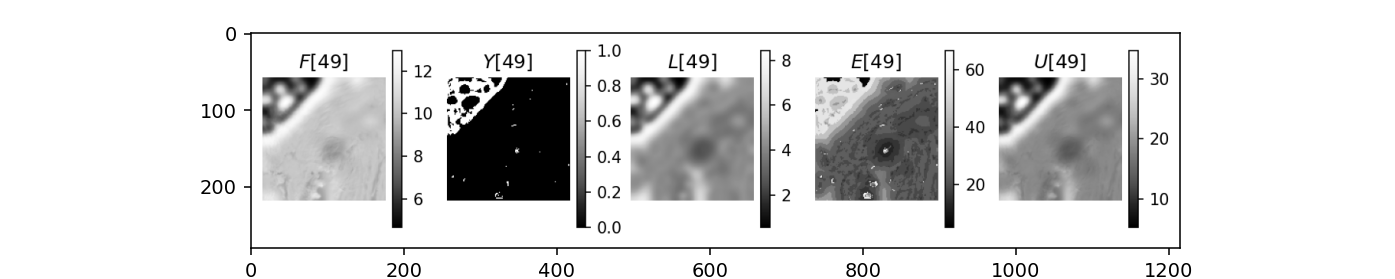

In [292]:
# Saving all the pulse images in each iteration and finally showing the oscillation
saveFigure()
oscillation(name="oscillation")

## Module 3: Image Fusion Application with Improved PCNN
Improved PCNN model. Here the model structure is changed little bit. Here internal activity, U is the ultimate result of the fusion. Implementing this version of PCNN where multi focus and only 2 images are used for fusion. But here all the 34 bands of MODIS images are used except the 13 and 14 bands for simplicity as it has high and lo version available.

#### Collecting Bands
Collecting 34 bands from MODIS image for fusion to observe the model of PCNN for image fusion.

In [316]:
inp_fusion = []

for i in range(36):
    if (i != 12 and i != 13):
        modis_scene.load([str(i + 1)])

for i in range(36):

    if (i != 12 and i != 13):
        image = resize(img_to_array(modis_scene[str(i + 1)]), (128, 128),  mode = 'constant', preserve_range = True)
        image = image/255.0
        print(image.shape)
        image = np.matrix(image)
        image = np.array(image)
        inp_fusion.append(image)
    
len(inp_fusion)

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


34

### Simplified Improved PCNN for Fusion
The main difference from traditional PCNN is here exponential decay factor for feeding and linking compartment has been removed. Another big difference is here beta is not constant for every image rather every band has different beta value. Also step function is changed here as now final output is not binary rather either zero or threshold value.

In [317]:
class PCNNFusion:
    
    edfE = 0.8
    vE = 50.0
    vF = 8.0
    vL = 8.0

    def __init__ (self, dim, beta):
        
        self.F = np.zeros(dim, float)
        self.L = np.zeros(dim, float)
        self.E = np.zeros(dim, float) + 0.0001
        self.Y = np.zeros(dim, float)
        self.beta = beta
        
        
    def pulse (self, inp):
        
        if self.Y.sum() > 0:
            previous_pulse = cspline2d(self.Y.astype(float), 90)
        else:
            previous_pulse = np.zeros(self.Y.shape, float)
            
        self.F = inp + self.vF * previous_pulse
        self.L = inp + self.vL * previous_pulse
        U = self.F + self.beta * self.L
        
        if U >= self.E:
            self.Y = self.E
        else:
            self.Y = 0
        
        self.E = self.edfE * self.E + self.vE * self.Y + 0.1

#### Fusion Operation and Beta assignment
34 bands are initialized with PCNN and used for fusion. In the paper they used adaptive beta as they have multi focus image but here we have used not adaptive but different beta for different band images. For practical and effective result beta should be different always otherwise same linking coefficient will result in bad performance of the model.

In [319]:
iteration = 100

band_list = []
beta_list = [0.1, 0.3, 0.2, 0.5, 0.4, 0.1, 0.3, 0.2, 0.5, 0.4, 0.1, 0.3, 0.2, 0.5, 0.4, 0.1, 0.3, 0.2, 0.5, 0.4, 0.1, 0.3, 0.2, 0.5, 0.4, 0.1, 0.3, 0.2, 0.5, 0.4,0.3, 0.2, 0.5, 0.4]

for i in range(34):
    band_list.append(PCNNFusion(inp_fusion[i].shape, beta_list[i]))

band_list

In [322]:
F, L, U, Y, E = [], [], [], [], []

for i in range(iteration):
    
    
    for j in range(34):
        
        band_list[j].pulse(inp_fusion[j])
        
        F.append((band_list[j].F + 0) / 255)
        L.append((band_list[j].L + 0) / 255)
        U.append((band_list[j].F) * (1 + ((band_list[j].beta) / 255) * ((band_list[j].L) / 255)))
        Y.append((band_list[j].Y + 0) / 255)
        E.append((band_list[j].E + 0) / 255)
    

<IPython.core.display.Javascript object>


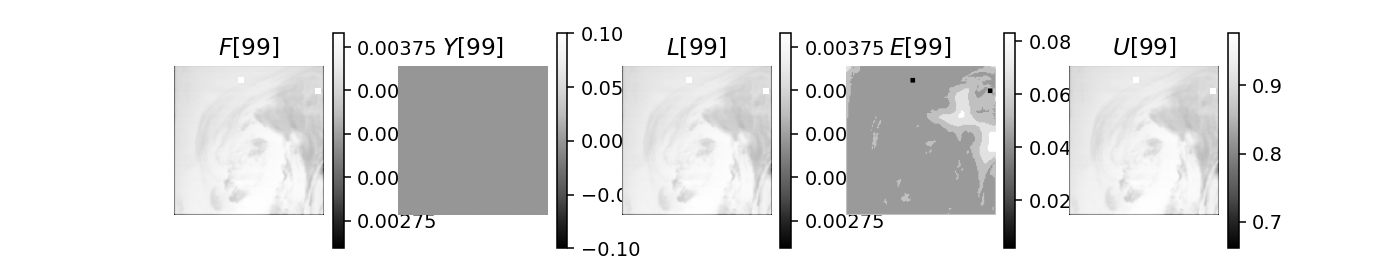

<IPython.core.display.Javascript object>


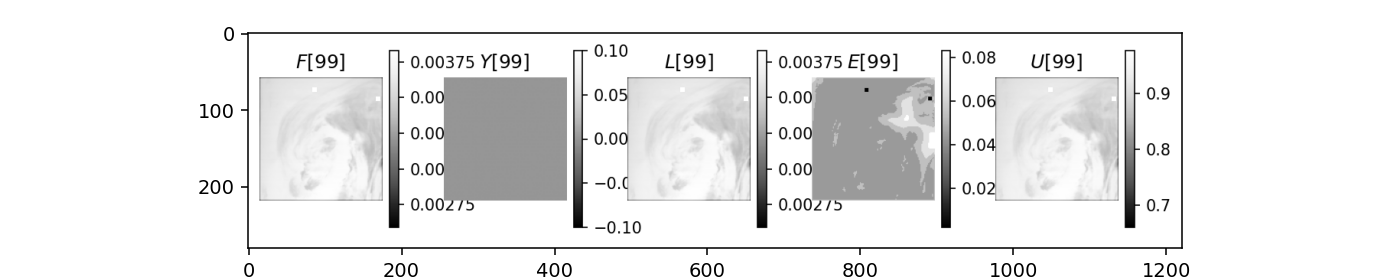

In [323]:
saveFigure()
oscillation(name="fusion")

In [297]:
modis_scene.unload

<bound method Scene.unload of <satpy.scene.Scene object at 0x1bcf37ac0>>